In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [3]:
!gdown 'https://drive.google.com/uc?id=166A3i3YN3bpHDYmMORDj4Ugmz3iBT-7S'

Downloading...
From (original): https://drive.google.com/uc?id=166A3i3YN3bpHDYmMORDj4Ugmz3iBT-7S
From (redirected): https://drive.google.com/uc?id=166A3i3YN3bpHDYmMORDj4Ugmz3iBT-7S&confirm=t&uuid=fc82b399-2308-471e-88c7-1efd9ad60088
To: /mnt/WorkingDrive/Automated-Intrusion-Detection-System-/notebook/dataset.csv
100%|████████████████████████████████████████| 277M/277M [00:29<00:00, 9.42MB/s]


In [4]:
df1 = pd.read_csv('out.csv')

In [7]:
df1['Label'].value_counts()

Label
0    100000
3     80000
5     75000
2     65000
1     13835
6      2180
4      2013
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df1['Label'] = le.fit_transform(df1['Label'])

In [9]:
from sklearn.preprocessing import StandardScaler
#Scaling every column in the dataframe
scaler = StandardScaler()
df1.iloc[:, :-1] = pd.DataFrame(scaler.fit_transform(df1.iloc[:, :-1]), columns=df1.iloc[:, :-1].columns)

/tmp/ipykernel_30002/745182219.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        -0.356131
1        -0.356131
2        -0.356131
3        -0.356131
4        -0.356131
            ...   
338023   -0.356131
338024   -0.356131
338025   -0.356131
338026   -0.356131
338027   -0.356131
Name: Destination Port, Length: 338028, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.iloc[:, :-1] = pd.DataFrame(scaler.fit_transform(df1.iloc[:, :-1]), columns=df1.iloc[:, :-1].columns)
/tmp/ipykernel_30002/745182219.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        -0.399763
1        -0.403200
2        -0.539234
3        -0.397450
4        -0.404188
            ...   
338023   -0.529228
338024   -0.293493
338025   -0.312567
338026   -0.534257
338027   -0.507336
Name: Flow Duration, 

In [10]:
correlation = df1.select_dtypes(include='float64').corr().abs()

In [11]:
upper_triangle = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

to_drop.append('Destination Port')
to_drop.append('act_data_pkt_fwd')
df = df1.drop(columns=to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338028 entries, 0 to 338027
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow Duration                338028 non-null  float64
 1   Total Fwd Packets            338028 non-null  float64
 2   Total Length of Fwd Packets  338028 non-null  float64
 3   Fwd Packet Length Max        338028 non-null  float64
 4   Fwd Packet Length Min        338028 non-null  float64
 5   Fwd Packet Length Mean       338028 non-null  float64
 6   Bwd Packet Length Max        338028 non-null  float64
 7   Bwd Packet Length Min        338028 non-null  float64
 8   Flow Bytes/s                 338028 non-null  float64
 9   Flow Packets/s               338028 non-null  float64
 10  Flow IAT Mean                338028 non-null  float64
 11  Flow IAT Std                 338028 non-null  float64
 12  Flow IAT Min                 338028 non-null  float64
 13 

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000000)
y_score = model.fit(X_train, y_train).predict_proba(X_test)

In [15]:
import joblib

joblib.dump(model, 'regression_model.joblib')

['regression_model.joblib']

In [16]:
y_pred = model.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

#y_pred = model.predict(X_test)

rec = recall_score(y_test, y_pred, average=None)
pre = precision_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {rec}')
print(f'Precision: {pre}')
print(f'F1 Score: {f1}')

Accuracy: 0.9377274206431382
Recall: [0.86189617 0.78597122 0.99737472 0.97783205 0.01785714 0.99847853
 0.85714286]
Precision: [0.93098782 0.83301563 0.97856061 0.90558488 0.31818182 0.97073767
 0.76518219]
F1 Score: [0.89511072 0.80880992 0.98787809 0.94032277 0.03381643 0.9844127
 0.80855615]


# XGBoost

In [18]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': 7,
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

num_round = 100  # Number of boosting iterations
bst = xgb.train(params, dtrain, num_round)

y_pred = bst.predict(dtest)

In [59]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

#y_pred = model.predict(X_test)

rec = recall_score(y_test, y_pred, average=None)
pre = precision_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {rec}')
print(f'Precision: {pre}')
print(f'F1 Score: {f1}')

Accuracy: 0.9988314646628997
Recall: [0.99816103 0.9981838  0.99954104 0.99968662 0.97       0.99959596
 0.98241758]
Precision: [0.99870705 0.99963623 0.99992348 0.99812265 0.97979798 0.99925951
 0.99554566]
F1 Score: [0.99843397 0.99890949 0.99973222 0.99890402 0.97487437 0.99942771
 0.98893805]


In [60]:
joblib.dump(bst, 'xgboost_model.joblib')

['xgboost_model.joblib']

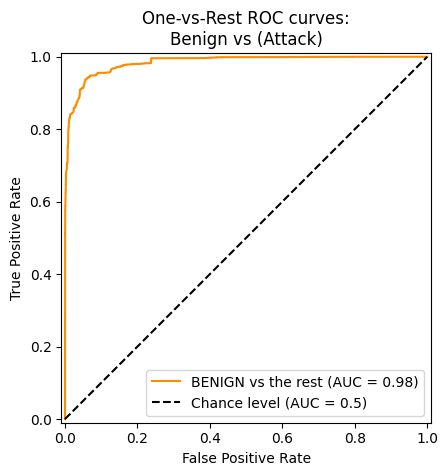

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

class_of_interest = 'BENIGN'
#class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id = 0

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nBenign vs (Attack)",
)

#Neural Network

In [11]:
import tensorflow as tf
from tensorflow.keras import layers

In [84]:
model = tf.keras.Sequential(
    [layers.InputLayer(shape=(41,)),
     layers.Dense(128, activation='relu'),
     layers.Dense(128,activation='relu'),
     layers.Dense(7, activation='softmax')]
)

In [85]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 128)                 │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,791 (89.03 KB)

 Trainable params: 22,791 (89.03 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

In [88]:
from sklearn.preprocessing import OneHotEncoder

y_onehot_train = OneHotEncoder().fit_transform(y_train.values.reshape(-1,1)).toarray()

In [89]:
history = model.fit(X_train, y_onehot_train, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9184 - f1_score: 0.7490 - loss: 0.2623 - precision: 0.9440 - recall: 0.8857 - val_accuracy: 0.9707 - val_f1_score: 0.9136 - val_loss: 0.1009 - val_precision: 0.9722 - val_recall: 0.9688
Epoch 2/30
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9654 - f1_score: 0.8999 - loss: 0.0996 - precision: 0.9667 - recall: 0.9643 - val_accuracy: 0.9668 - val_f1_score: 0.9075 - val_loss: 0.1009 - val_precision: 0.9670 - val_recall: 0.9667
Epoch 3/30
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9702 - f1_score: 0.9080 - loss: 0.0888 - precision: 0.9709 - recall: 0.9696 - val_accuracy: 0.9716 - val_f1_score: 0.9140 - val_loss: 0.0980 - val_precision: 0.9720 - val_recall: 0.9712
Epoch 4/30
3381/3381 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9719 - f1_score: 0.9095 - loss: 0.0818 - precision: 0.9725 - recall: 0.9714 - val_accuracy: 0.9759 - val_f1_score: 0.9203 - val_loss: 0.0896 - val_precision: 0.9763 -

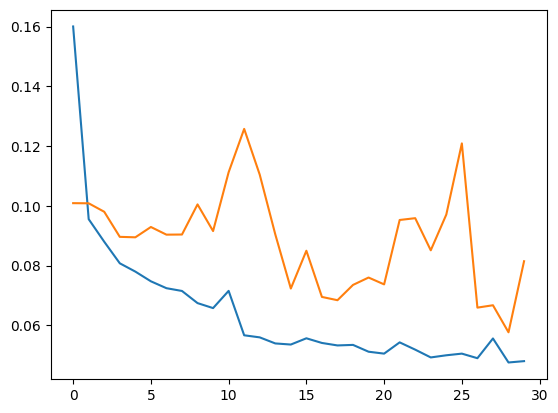

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

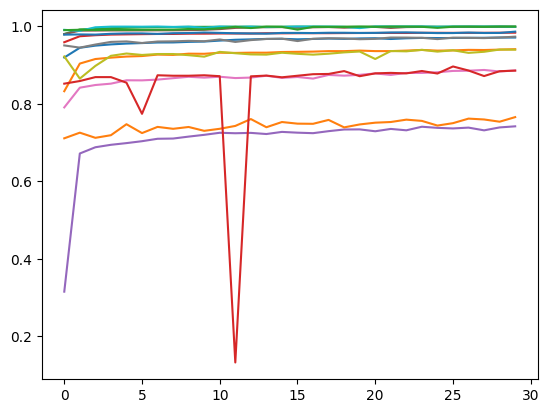

In [91]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

In [92]:
def return_max(y):
  dim = y.shape[0]
  y_ret = np.zeros(shape=(dim, 7))
  for i in range(y.shape[0]):
    max = np.max(y[i])
    y_ret[i] = np.where(y[i] == max, 1, 0)
  return y_ret

In [93]:
y_onehot_test = OneHotEncoder().fit_transform(y_test.values.reshape(-1,1)).toarray()

In [94]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y_pred = model.predict(X_test)
y_pred = return_max(y_pred)
rec = recall_score(y_onehot_test, y_pred, average=None)
pre = precision_score(y_onehot_test, y_pred, average=None)
f1 = f1_score(y_onehot_test, y_pred, average=None)
print(f'Accuracy: {accuracy_score(y_onehot_test, y_pred)}')
print(f'Recall: {rec}')
print(f'Precision: {pre}')
print(f'F1 Score: {f1}')

2113/2113 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Accuracy: 0.9834925894151406
Recall: [0.96491575 0.93857036 0.99875921 0.99766606 0.63144963 0.99940429
 0.93095238]
Precision: [0.98135491 0.94278235 0.99829471 0.9725741  0.94139194 0.998347
 0.82489451]
F1 Score: [0.9730659  0.94067164 0.9985269  0.9849603  0.75588235 0.99887536
 0.87472036]


#Inference

In [13]:
df2 = pd.read_csv('output.csv')

In [14]:
to_infer = df2.columns.values

In [15]:
trained = df.columns.values

In [16]:
def intersect(col1, col2):
  result = [value for value in col1 if value in col2]
  return result

In [17]:
merged = intersect(to_infer, trained)

In [18]:
df_merged = df2[merged]

In [19]:
model = joblib.load('xgboost_model.joblib')

In [22]:
import xgboost as xgb

dtest_predict = xgb.DMatrix(df_merged)

In [23]:
prediction = model.predict(dtest_predict)

In [24]:
prediction.size

205

In [25]:
prediction

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)